# Дипломная работа, Полушина В.В.
На тему: "Потребление электроэнергии в 1-ой квартире в МКД".

Введение: Для проведения анализа взята статистика по потреблению электроэнергии в многоквартирном доме на примере 1-ой квартиры (40 квадратов) в период с 2015 по 2021 год включительно.
Цель: Проведение исследования данных и построение прогноза потребления электроэнергии в 1-ой квартире на 1 год вперед.
Задачи:
1.   Провести анализ данных о потреблении электроэнергии в квартире;
2.   Построить прогноз потребления электроэнергии.

# Этап 1: Импорт библиотек, ознакомление с данными.

In [21]:
!pip install pmdarima # загружаем pmdarima

In [22]:
!pip install fbprophet # загружаем fbprophet

In [23]:
# импорт библиотек и функций
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# импорт моделей 
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков

from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Профет
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненцальное сглаживание

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [24]:
# Загрузка датасета и его просмотр
df = pd.read_csv('ДатаСетЭЭвКВ3.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df)) # количество строк в датасете
print(df.head())

84
            Consumption
Date                   
2015-01-01      65.9628
2015-02-01      59.1620
2015-03-01      57.3140
2015-04-01      52.9718
2015-05-01      49.1707


In [25]:
# Проверка, что все выгрузилось корректно и последовательно
df.head(84)

,Consumption
Date,
2015-01-01,65.9628
2015-02-01,59.1620
2015-03-01,57.3140
2015-04-01,52.9718
2015-05-01,49.1707
...,...
2021-08-01,63.2704
2021-09-01,65.5107
2021-10-01,66.0620


In [26]:
# Смотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2015-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


In [27]:
# Осуществляем проверку, есть ли пропуски в датасете
df.isna()

,Consumption
Date,
2015-01-01,False
2015-02-01,False
2015-03-01,False
2015-04-01,False
2015-05-01,False
...,...
2021-08-01,False
2021-09-01,False
2021-10-01,False


In [28]:
# проверим, везде ли отсутствуют пропуски
df_check = df.isna()

for i in df_check.columns:
    print(f'Для признака {i} пропуски: ', df_check[i].unique())

Для признака Consumption пропуски:  [False]


Вывод по этапу 1: Были загружены необходимые библиотеки, функции, модели, метрики. Был загружен датасет. Датасет был рассмотрен на предмет того, что с ним можно работать: что отсутствуют пропуски, проверен формат данных и дата находится в порядке возрастания. 

##Этап 2: EDA (exploratory data analysis) или разведочный анализ данных.


In [29]:
# еще раз смотрим на датасет
df.head(84)

,Consumption
Date,
2015-01-01,65.9628
2015-02-01,59.1620
2015-03-01,57.3140
2015-04-01,52.9718
2015-05-01,49.1707
...,...
2021-08-01,63.2704
2021-09-01,65.5107
2021-10-01,66.0620


In [30]:
# проведем расчет основных статистических метрик
df.describe()

,Consumption
count,84.000000
mean,61.769480
std,8.553208
min,41.588000
25%,55.951750
50%,61.925850
75%,67.832650
max,84.404000


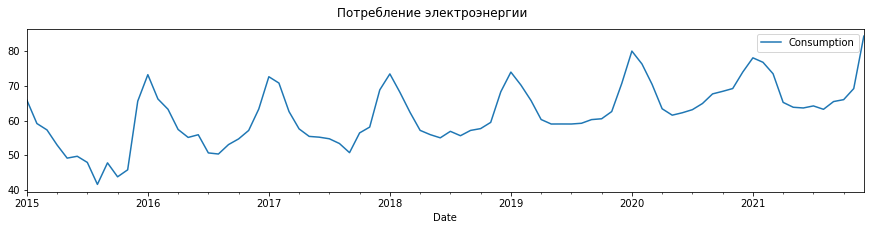

In [31]:
#построим общий график
df[['Consumption']].plot(subplots=True, figsize=(15, 3), title = 'Потребление электроэнергии');

Промежуточный вывод: согласно графику видно, что рост потребления электроэнергии растет раз в год. Также с каждым годом потребление электроэнергии растет. Высокое потребление связано с зимой, в холодное время года растет потребление из-за короткого светового дня; установка дополнительной электроники (увлажнители воздуха, обогреватели).

[Text(0, 0.5, 'Уровень потребления'), Text(0.5, 0, '')]

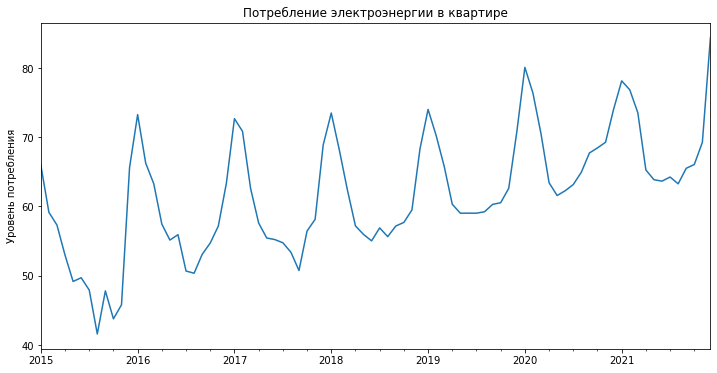

In [32]:
# строим временной ряд по колонке 'Потребление' из загруженного датасета

title = 'Потребление электроэнергии в квартире' # название графика
ylabel = 'Уровень потребления' # название оси Y
xlabel = '' # по сравнению с ожидаемым результатом не указываем название оси Х

ax = df['Consumption'].plot(figsize=(12,6),title=title) # добавлем заголовок
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

Промежуточный вывод: Видим высокий уровень корреляции, между потреблением и месяцем. Также выявлен положительный тренд потребления электроэнергии. Строим гипотезу: будет ли в будущем расти потребление электроэнергии с учетом появления новых электроприборов и работы на дому с учетом сезонности.

# Этап 3: Построение моделей, анализ результатов.

In [33]:
# выделяем выборки, где тестовая размера 1 год
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [34]:
# посмотрим на обучающую выборку
train.head()

,Consumption
Date,
2015-01-01,65.9628
2015-02-01,59.1620
2015-03-01,57.3140
2015-04-01,52.9718
2015-05-01,49.1707


In [35]:
# посмотрим на тестовую выборку
test.head()

,Consumption
Date,
2021-01-01,78.1368
2021-02-01,76.8499
2021-03-01,73.5377
2021-04-01,65.2676
2021-05-01,63.8617


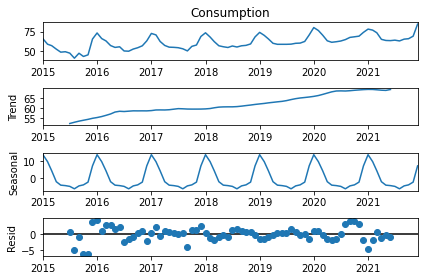

In [36]:
# строим декомпозицию временного ряда (ETS декомпозиция)
r = seasonal_decompose(df['Consumption'], model='additive')

r.plot();

Промежуточный вывод: Наблюдаем годовую сезонность и положительный тренд.

Задачи:

1. описать модель
2. подобрать оптимальные параметры
3. создать модель
4. обучить модель
5. сделать прогноз на период тестовой выборки
6. сравнить прогноз с тестовой выборкой (построить график)
7. оценить качество прогноза
8. сделать прогноз на год
9. сделать выводы о работе данного метода прогнозирования

Модель 1: SARIMAX

In [37]:
# запускаем pmdarima.auto_arima чтобы получить набор параметров
auto_arima(df['Consumption'],seasonal=True,m=12).summary() # включаем сезонность и указываем период сезонности равный 1 год

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -211.927
Date:                              Sat, 19 Mar 2022   AIC                            429.853
Time:                                      08:38:23   BIC                            437.110
Sample:                                           0   HQIC                           432.768
                                               - 84                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9978      0.010    100.247      0.000       0.978       1.017
ma.S.L12      -0.8862      0.244     -3.633      0.000      -1.364      -0.408
sigma2         6.7788      1.717      3.948      0.000       3.413      10.144
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                21.98
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             0.49
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Промежуточные выводы:

Получилась модель с параметрами SARIMAX(0, 1, 0)x(1, 0, 1, 12)

In [38]:
# создаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['Consumption'],order=(0, 1, 0), seasonal_order=(1, 0, 1, 12))

# обучаем модель на обучающей выборке данных
results_sarimax = model_sarimax.fit()

# получаем результаты
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Consumption   No. Observations:                   72
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -183.140
Date:                              Sat, 19 Mar 2022   AIC                            372.280
Time:                                      08:39:22   BIC                            379.068
Sample:                                  01-01-2015   HQIC                           374.979
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9639      0.038     25.644      0.000       0.890       1.038
ma.S.L12      -0.5564      0.209     -2.658      0.008      -0.967      -0.146
sigma2         7.9335      1.226      6.471      0.000       5.531      10.336
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                28.49
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
# получаем предсказанные значения и пытаемся оценить качество прогноза
start=len(train) # первая точка в тестовом множестве
end=len(train)+len(test)-1 # последняя точка в тестовом множестве

# предсказываем значения,передав модели results точку начала и окончания
predictions = results_sarimax.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions SARIMAX(0, 1, 0)x(1, 0, 1, 12)')

[Text(0, 0.5, 'Объем потребления'), Text(0.5, 0, '')]

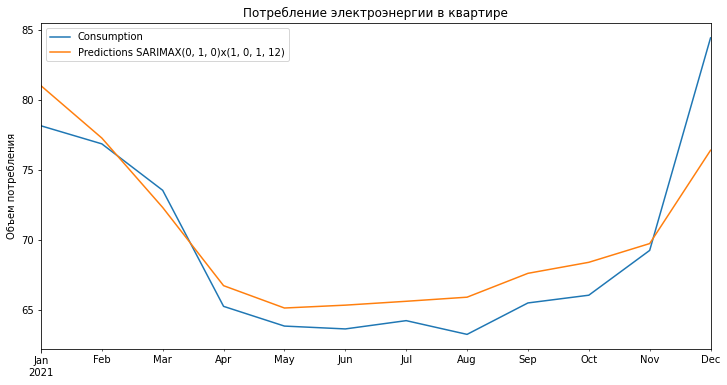

In [40]:
# сравниваем результаты

title = 'Потребление электроэнергии в квартире' # название графика
ylabel = 'Объем потребления' # название оси Y
xlabel = '' # по сравнению с ожидаемым результатом не указываем название оси Х


ax = test['Consumption'].plot(legend=True, figsize=(12,6),title=title) # добавлем заголовок
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [42]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['Consumption'], predictions)
mse_error = mean_squared_error(test['Consumption'], predictions)
rmse_error = rmse(test['Consumption'], predictions)
mape_error = np.mean(np.abs(predictions - test['Consumption'])/test['Consumption'])*100

print(f'SARIMAX(0, 1, 0)x(1, 0, 1, 12) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(0, 1, 0)x(1, 0, 1, 12) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(0, 1, 0)x(1, 0, 1, 12) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(0, 1, 0)x(1, 0, 1, 12) MAPE Error: {mape_error:11.10}')

SARIMAX(0, 1, 0)x(1, 0, 1, 12) MAE Error:  2.16142509
SARIMAX(0, 1, 0)x(1, 0, 1, 12) MSE Error:  8.32180162
SARIMAX(0, 1, 0)x(1, 0, 1, 12) RMSE Error: 2.884753303
SARIMAX(0, 1, 0)x(1, 0, 1, 12) MAPE Error:  3.00844232


In [43]:
#делаем прогноз на будущее - 1 год вперед

# обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df['Consumption'],order=(0, 1, 0), seasonal_order=(1, 0, 1, 12))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Consumption   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -211.927
Date:                              Sat, 19 Mar 2022   AIC                            429.853
Time:                                      08:41:17   BIC                            437.110
Sample:                                  01-01-2015   HQIC                           432.768
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9978      0.010    100.247      0.000       0.978       1.017
ma.S.L12      -0.8862      0.244     -3.633      0.000      -1.364      -0.408
sigma2         6.7788      1.717      3.948      0.000       3.413      10.144
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                21.98
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             0.49
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

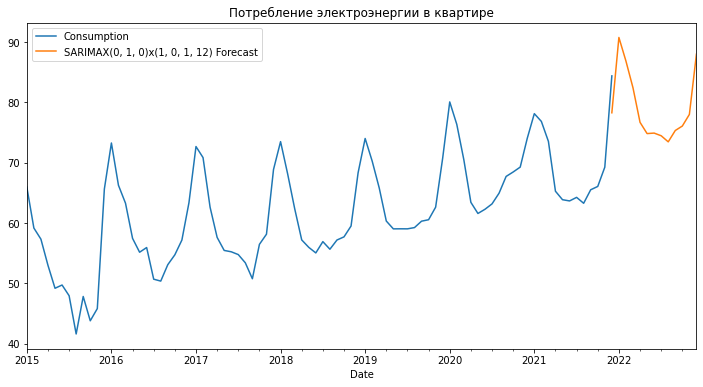

In [44]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df)-1,len(df)+11,typ='levels').rename('SARIMAX(0, 1, 0)x(1, 0, 1, 12) Forecast')

#строим график на будущее
ax = df['Consumption'].plot(legend=True, figsize=(12,6),title='Потребление электроэнергии в квартире') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

### Выводы работы метода SARIMAX:


1.   Модель показала себя хорошо, RMSE=2.9 кВТ/ч, это очень хороший показатель.
2.   Также процент рассчитанной ошибки MAPE=3%, это хороший результат.
3. Согласно графику, на будущее видим, что тренд и высота амплитуда были отображены корректно, общая динамика прослеживается. 



Модель 2: PROPHET

In [86]:
# подготовим данные для модели
train_prophet = train.reset_index() # индекс сбросим, чтобы работать только с колонками
test_prophet = test.reset_index() # индекс сбросим, чтобы работать только с колонками

df_new=df.reset_index()
df_new_prophet = df_new[['Date','Consumption']]
df_new_prophet.columns = ['ds', 'y'] # переименовали столбцы

# переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] # переименовали столбцы
test_prophet.columns = ['ds', 'y'] # переименовали столбцы

#выделим тестовую (последний год) и обущающую (до последнего года) выборку
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [87]:
df_new_prophet.head()

,ds,y
0,2015-01-01,65.9628
1,2015-02-01,59.1620
2,2015-03-01,57.3140
3,2015-04-01,52.9718
4,2015-05-01,49.1707


In [88]:
train_prophet.head() # посмотрим преобразование после переименования колонок

,ds,y
0,2015-01-01,65.9628
1,2015-02-01,59.1620
2,2015-03-01,57.3140
3,2015-04-01,52.9718
4,2015-05-01,49.1707


In [89]:
test_prophet.head()

,ds,y
0,2021-01-01,78.1368
1,2021-02-01,76.8499
2,2021-03-01,73.5377
3,2021-04-01,65.2676
4,2021-05-01,63.8617


In [90]:
model = Prophet()
model.fit(train_prophet) # подогнали модель под наши данные

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Промежуточные выводы:
Как видим, алгоритм сам нам подсказывает, что он проигнорировал, выбирая параметры.

Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.

- недельную сезонность (для недельной сезонности нам нужно иметь данные минимум за месяц, чтобы суметь использовать ее в модели)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

- дневную сезонность (дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по месяцам).

Зато он обнаружил годовую сезонность и использовал его при настройке модели.

In [91]:
future = model.make_future_dataframe(periods=12, freq='MS') # говорим профету сделать дата-фрейм на 12 месяцев
future.tail(12) # выводим 12 строк с конца

,ds
72,2021-01-01
73,2021-02-01
74,2021-03-01
75,2021-04-01
76,2021-05-01
77,2021-06-01
78,2021-07-01
79,2021-08-01
80,2021-09-01
81,2021-10-01


In [92]:
# предсказываем значения по модели, доверительный интервал по умолчанию 95%
forecast = model.predict(future)
forecast.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,51.373350,63.538422,68.340578,51.373350,51.373350,14.519475,14.519475,14.519475,14.519475,14.519475,14.519475,0.0,0.0,0.0,65.892825
1,2015-02-01,51.712037,58.510079,63.408349,51.712037,51.712037,9.311873,9.311873,9.311873,9.311873,9.311873,9.311873,0.0,0.0,0.0,61.023910
2,2015-03-01,52.017948,52.990498,57.834894,52.017948,52.017948,3.410455,3.410455,3.410455,3.410455,3.410455,3.410455,0.0,0.0,0.0,55.428404
3,2015-04-01,52.356635,48.319151,53.151474,52.356635,52.356635,-1.570318,-1.570318,-1.570318,-1.570318,-1.570318,-1.570318,0.0,0.0,0.0,50.786317
4,2015-05-01,52.684397,46.423801,51.186946,52.684397,52.684397,-3.874564,-3.874564,-3.874564,-3.874564,-3.874564,-3.874564,0.0,0.0,0.0,48.809833


Основные поля в прогнозе следующие:

- ds — дата прогноза

- yhat — спрогнозированное значение

- yhat_lower — нижняя граница доверительного интервала для прогноза

- yhat_upper — верхняя граница доверительного интервала для прогноза

In [93]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12) # оставим только нужные

,ds,yhat,yhat_lower,yhat_upper
72,2021-01-01,83.240204,80.841665,85.671834
73,2021-02-01,80.922010,78.401386,83.244331
74,2021-03-01,75.684833,73.346636,78.179293
75,2021-04-01,70.005214,67.437196,72.457285
76,2021-05-01,67.948115,65.355217,70.400906
77,2021-06-01,68.148552,65.553233,70.555909
78,2021-07-01,67.079790,64.759001,69.542707
79,2021-08-01,66.520758,63.978383,69.005727
80,2021-09-01,68.280853,65.907603,70.763201
81,2021-10-01,69.832416,67.284596,72.323279


Также с помощью метода .plot() прогноз можно построить на графике и посмотреть визуально его адекватность.

Черные точки — наши данные.

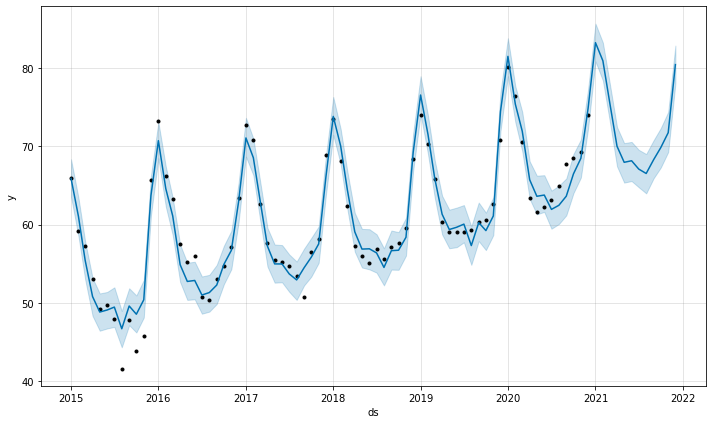

In [94]:
model.plot(forecast);

Кроме того, Prophet позволяет также наглядно разложить ряд на основные компоненты — тренд и сезонность:

plot_components() — возвращает несколько графиков, среди которых тренд и столько сезонностей, сколько он найдет.

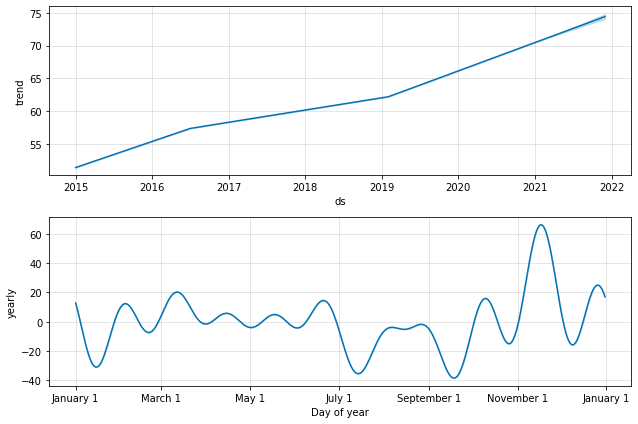

In [55]:
model.plot_components(forecast);

Промежуточные выводы:
Видим, что тренд потребления электроэнергии возрастающий и у нас есть годовая сезонность. Видим каким образом изменяется потребление по месяцам.

In [95]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE

mae_error = mean_absolute_error(test_prophet['y'], forecast['yhat'].tail(12))
mse_error = mean_squared_error(test_prophet['y'], forecast['yhat'].tail(12))
rmse_error = rmse(test_prophet['y'], forecast['yhat'].tail(12))
mape_error = np.mean(np.abs(forecast['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {mae_error:11.10}')
print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MAE Error: 3.642359006
Prophet MSE Error: 14.07615716
Prophet RMSE Error: 3.751820512
Prophet MAPE Error: 23.45530511


In [96]:
# делаем прогноз на будущее - 1 год вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='additive')
fut_model_prophet.fit(df_new_prophet)

# говорим профету сделать дата-фрейм на 1 год вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=12)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [98]:
# устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [99]:
# убедимся в изменениях
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2015-01-01,2015-01-01,52.227147,63.618380,68.782299,52.227147,52.227147,13.888081,13.888081,13.888081,13.888081,13.888081,13.888081,0.0,0.0,0.0,66.115228
2015-02-01,2015-02-01,52.514599,58.778132,64.029329,52.514599,52.514599,8.778983,8.778983,8.778983,8.778983,8.778983,8.778983,0.0,0.0,0.0,61.293582
2015-03-01,2015-03-01,52.774233,52.612235,57.921918,52.774233,52.774233,2.551749,2.551749,2.551749,2.551749,2.551749,2.551749,0.0,0.0,0.0,55.325982
2015-04-01,2015-04-01,53.061685,47.819342,53.268573,53.061685,53.061685,-2.427485,-2.427485,-2.427485,-2.427485,-2.427485,-2.427485,0.0,0.0,0.0,50.634200
2015-05-01,2015-05-01,53.339864,46.229241,51.579204,53.339864,53.339864,-4.469533,-4.469533,-4.469533,-4.469533,-4.469533,-4.469533,0.0,0.0,0.0,48.870331


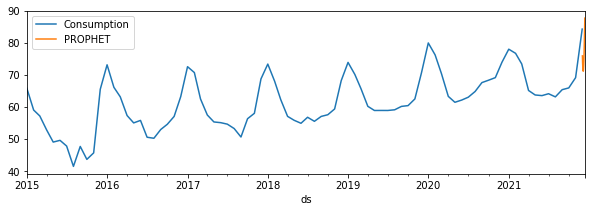

In [135]:
#строим график на будущее

ax = df['Consumption'].plot(legend=True, figsize=(10,3),title='Потребление электроэнергии в квартире') 
fut_fcast_prophet['yhat'].tail(12).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["Consumption", "PROPHET"]);

# Выводы работы метода PROPHET:


1. Модель показала себя хорошо, RMSE=3.7 кВт/ч, это хороший показатель.
2. Но процент рассчитанной ошибки MAPE=23,4%, это плохой результат, такому прогнозу определенно нельзя доверять.




Модель 2: "Экспоненциальное сглаживание" (Exponential smoothing)

In [116]:
# создаем модель с подобранными параметрами
model_exps = ExponentialSmoothing(train['Consumption'], seasonal_periods=12, trend = 'add') # годовая сезонность

In [117]:
# обучаем модель на обучающей выборке данных
model_exps.fit()

In [118]:
# посмотрим на подобранные параметры модели
model_exps.params

{'damping_trend': nan,
 'initial_level': 65.84891214889706,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': 0.11389291238298985,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.9999999850988388,
 'smoothing_seasonal': nan,
 'smoothing_trend': 0.0,
 'use_boxcox': False}

In [119]:
# предсказываем значения,передав модели results точку начала и окончания
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [120]:
# определяем точку начала для прогноза
test.index[0]

Timestamp('2021-01-01 00:00:00', freq='MS')

In [121]:
# определяем точку окончания для прогноза
test.index[-1]

Timestamp('2021-12-01 00:00:00', freq='MS')

In [122]:
prediction_exps

array([74.16309284, 74.27698576, 74.39087867, 74.50477158, 74.61866449,
       74.7325574 , 74.84645032, 74.96034323, 75.07423614, 75.18812905,
       75.30202197, 75.41591488])

In [123]:
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2021-01-01 00:00:00", periods=12, freq="M")

prediction_exps.columns = ['prediction_exps']

In [124]:
# проверим
prediction_exps.head(12)

,prediction_exps
2021-01-31,74.163093
2021-02-28,74.276986
2021-03-31,74.390879
2021-04-30,74.504772
2021-05-31,74.618664
2021-06-30,74.732557
2021-07-31,74.846450
2021-08-31,74.960343
2021-09-30,75.074236
2021-10-31,75.188129


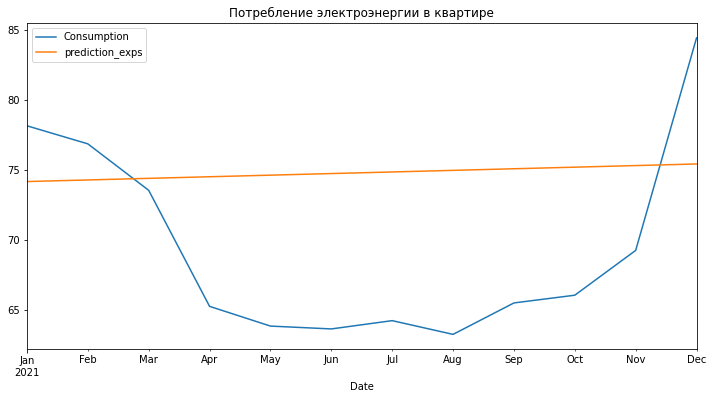

In [125]:
# сравниваем прогноз и тестовую выборку

title = 'Потребление электроэнергии в квартире' # название графика

ax = test['Consumption'].plot(legend=True, figsize=(12,6),title=title)
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [126]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['Consumption'], prediction_exps['prediction_exps'])
mse_error = mean_squared_error(test['Consumption'], prediction_exps['prediction_exps'])
rmse_error = rmse(test['Consumption'], prediction_exps['prediction_exps'])
mape_error = np.mean(np.abs(prediction_exps['prediction_exps'] - test['Consumption'])/test['Consumption'])*100

print(f'Exponential smoothing MAE Error: {mae_error:11.10}')
print(f'Exponential smoothing MSE Error: {mse_error:11.10}')
print(f'Exponential smoothing RMSE Error: {rmse_error:11.10}')
print(f'Exponential smoothing MAPE Error: {mape_error:11.10}')

Exponential smoothing MAE Error: 7.873279948
Exponential smoothing MSE Error: 73.98818795
Exponential smoothing RMSE Error: 8.601638678
Exponential smoothing MAPE Error:         nan


In [127]:
# делаем прогноз на год вперед

# обучаем модель на всем датасете
fut_model_exps = ExponentialSmoothing(df['Consumption'], seasonal_periods=12, trend = 'add') # годовая сезонность
fut_model_exps.fit()

# задаем точки будущего
fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df)-1, end=len(df)+11)

# преобразуем в датафрейм с индексами
fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range("2021-01-01 00:00:00", periods=13, freq="M")
fut_fcast_exps.columns = ['fut_fcast_exps']

In [128]:
#проверим
fut_fcast_exps.head(12)

,fut_fcast_exps
2021-01-31,69.477684
2021-02-28,84.626184
2021-03-31,84.848368
2021-04-30,85.070552
2021-05-31,85.292736
2021-06-30,85.514920
2021-07-31,85.737104
2021-08-31,85.959288
2021-09-30,86.181472
2021-10-31,86.403655


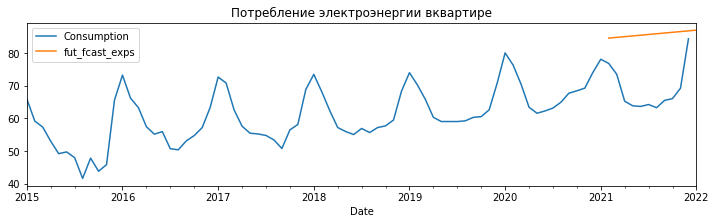

In [129]:
#строим график на будущее
title = 'Потребление электроэнергии вквартире' # название графика

ax = df['Consumption'].plot(legend=True, figsize=(12,3),title=title) 
fut_fcast_exps['fut_fcast_exps'].tail(12).plot(legend=True)
ax.autoscale(axis='x',tight=True)

Выводы работы метода "Экспоненциальное сглаживание" (Exponential smoothing):
1. Модель показала себя плохо, RMSE=8.6 кВт/ч, это не очень хороший показатель, слишком высокий уровень ошибки. Такому прогнозу нельзя доверять.


# Общие выводы:
- Проведен анализ данных с использованием современных методов обработки статистической информации.

- Рассчитаны основные статистические метрики, позволяющие судить о характере исследуемого явления.

- Результаты анализа представленных данных помогли выявить зависимость потребления электроэнергии в зависимости от сезона года.
- Сравнивая три модели прогноза, лучшего всего себя показала модель SARIMAX, согласно показателям ошибок RMSE (2,8 кВт/ч) и MAPE (3%) данная модель делает лучший прогноз, которому можно доверять.
